# Job Change Probability

# This notebook is to predict the probability of a candidate looking for a new job or will work for the company. The dataset is taken from Kaggle.

Features

- enrollee_id : Unique ID for candidate.
- city: City code.
- city_ development _index : Developement index of the city (scaled).
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline : Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- last_new_job: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

### The purpose of this notebook is to predict the probability of a candidate will work for the company

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [327]:
train_data = pd.read_csv('data/aug_train.csv')
test_data = pd.read_csv('data/aug_test.csv')

train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [328]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [329]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [330]:
# Drop duplicated rows based on enrollee_id
train_data.drop_duplicates(subset='enrollee_id', keep='first', inplace=True)
test_data.drop_duplicates(subset='enrollee_id', keep='first', inplace=True)

In [331]:
train_data.drop('enrollee_id', axis=1, inplace=True)
test_data.drop('enrollee_id', axis=1, inplace=True)

In [332]:
# Count number of rows in train and test data
print(train_data.shape)
print(test_data.shape)

(19158, 13)
(2129, 12)


In [333]:
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_train_data.corr()
correlation_matrix

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


<Axes: >

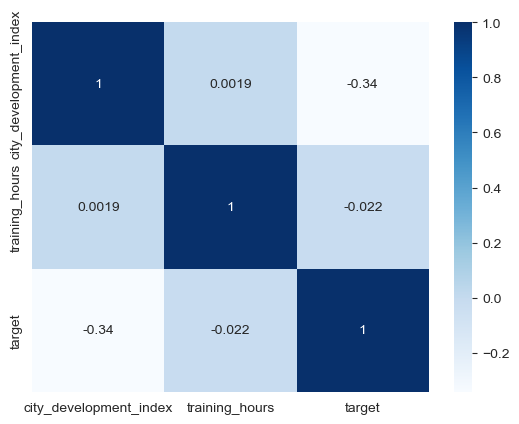

In [334]:
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')

In [335]:
# Check for missing values in train data
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


In [336]:
print(test_data.isnull().sum())

city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64


C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

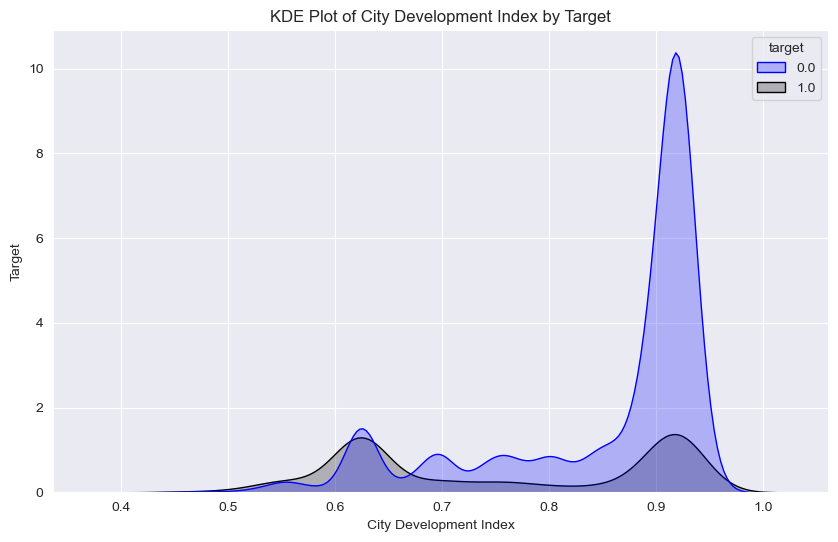

In [337]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data,x="city_development_index",hue="target",fill=True,palette=["blue","black"])
plt.xlabel("City Development Index")
plt.ylabel("Target")
plt.title("KDE Plot of City Development Index by Target")
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

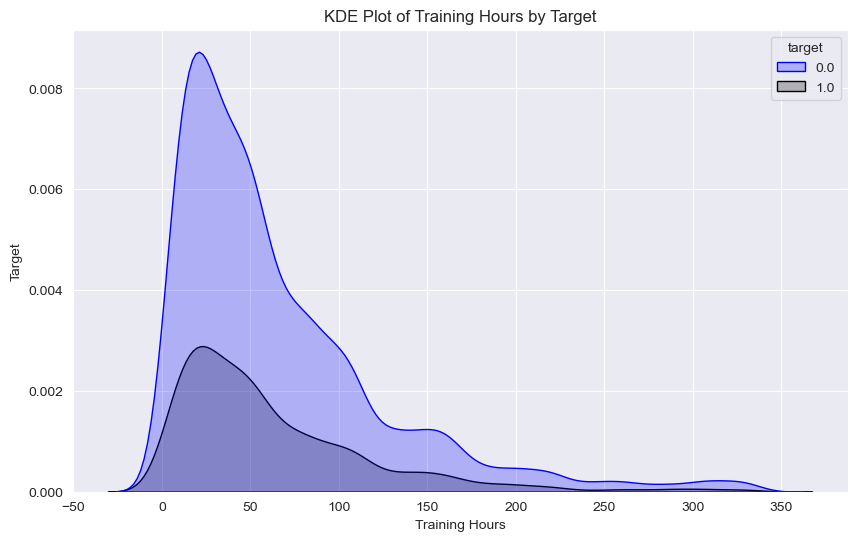

In [338]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data,x="training_hours",hue="target",fill=True,palette=["blue","black"])
plt.xlabel("Training Hours")
plt.ylabel("Target")
plt.title("KDE Plot of Training Hours by Target")
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


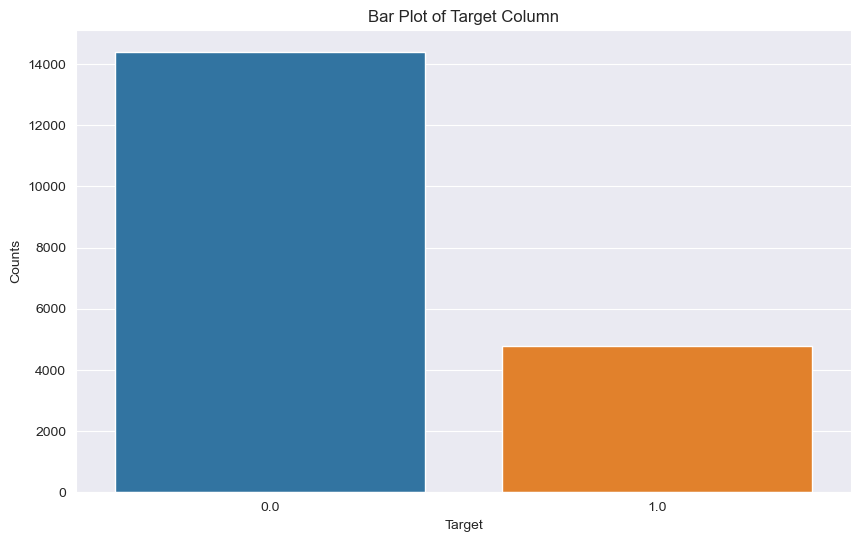

In [339]:
# Bar plot of counted target column
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=train_data)
plt.xlabel("Target")
plt.ylabel("Counts")
plt.title("Bar Plot of Target Column")
plt.show()

In [340]:
cat_features = []
num_features = []

X = train_data.drop(['target'], axis=1)

for column in X.columns:
    if X[column].dtype == "O": cat_features.append(column)
    else                     : num_features.append(column)


y = train_data['target']

print("Categorical features: ", cat_features, '\n')
print("Numerical features: ", num_features)

Categorical features:  ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'] 

Numerical features:  ['city_development_index', 'training_hours']


In [341]:
gender_counts = train_data['gender'].value_counts(dropna=False)

In [342]:
gender_counts

gender
Male      13221
NaN        4508
Female     1238
Other       191
Name: count, dtype: int64

In [343]:
# Replace NaN and missing values with ffill
train_data['gender'].ffill(inplace=True)
test_data['gender'].ffill(inplace=True)

In [344]:
train_data['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [345]:
print(train_data['gender'].isnull().sum())

0


C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


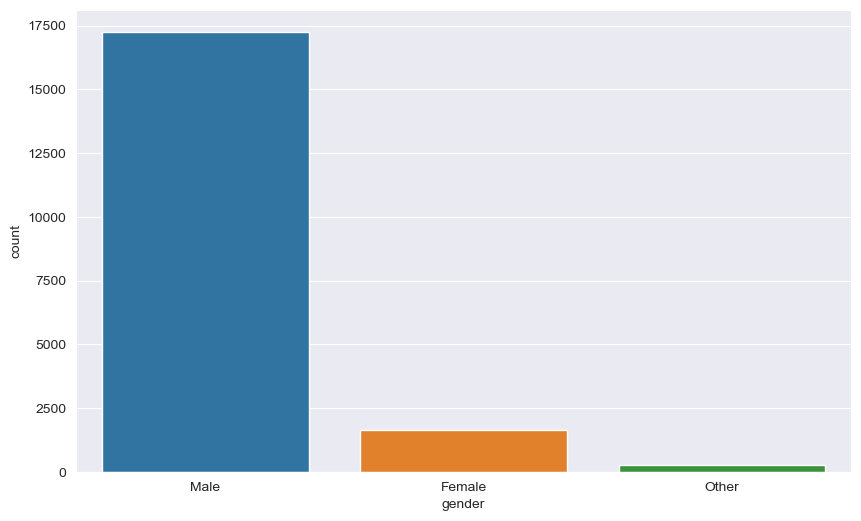

In [346]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='gender', data=train_data, order=train_data['gender'].value_counts().index)
plt.show()

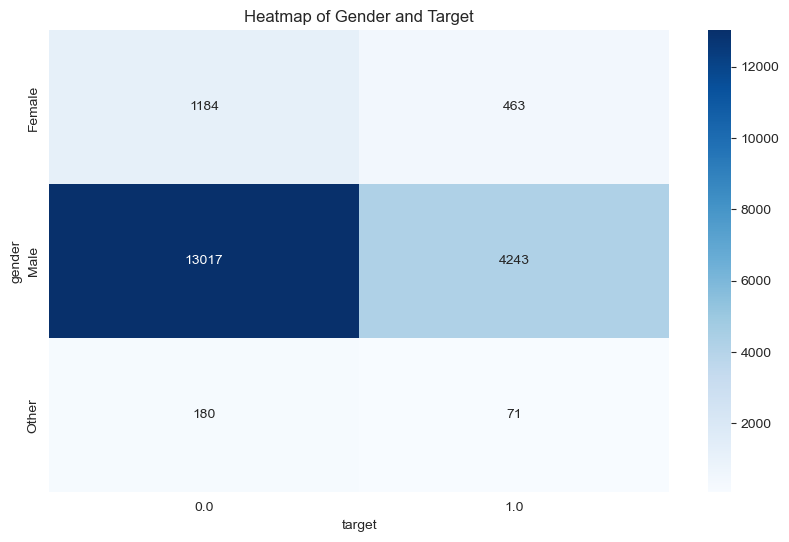

In [347]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['gender'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Gender and Target')
plt.show()

In [348]:
# Get unique values of enrolled_university
train_data['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', nan, 'Part time course'],
      dtype=object)

In [349]:
# Count of unique values in enrolled_university
train_data['enrolled_university'].value_counts(dropna=False)

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: count, dtype: int64

In [350]:
most_common = train_data['enrolled_university'].mode()[0]
train_data['enrolled_university'].fillna(most_common, inplace=True)

most_common = test_data['enrolled_university'].mode()[0]
test_data['enrolled_university'].fillna(most_common, inplace=True)

In [351]:
train_data['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', 'Part time course'],
      dtype=object)

In [352]:
print(train_data['enrolled_university'].isnull().sum())

0


In [353]:
print(test_data['enrolled_university'].isnull().sum())

0


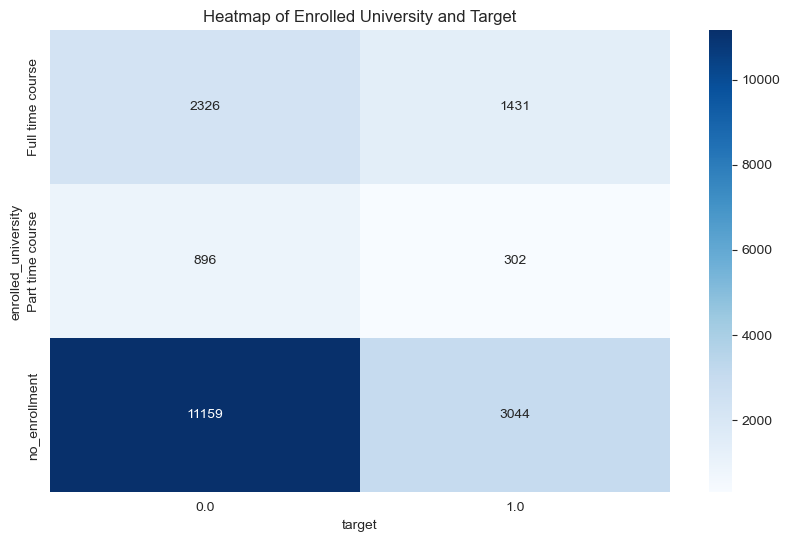

In [354]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['enrolled_university'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Enrolled University and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


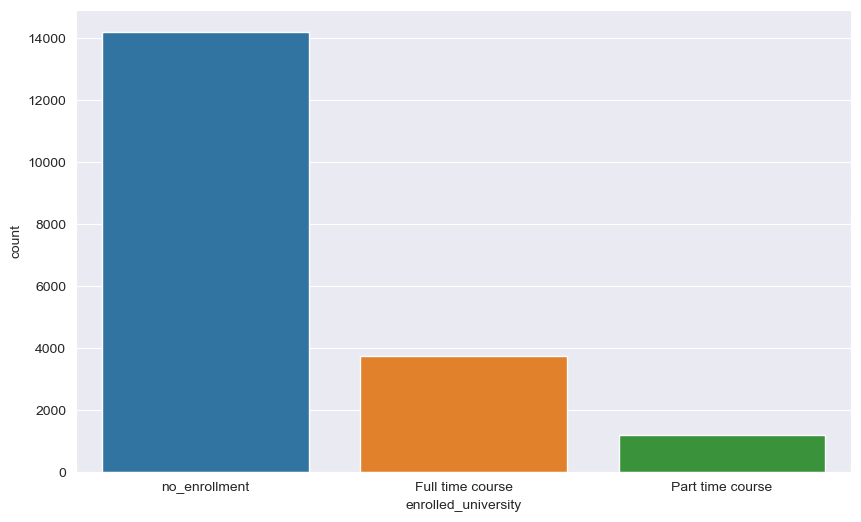

In [355]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='enrolled_university', data=train_data, order=train_data['enrolled_university'].value_counts().index)
plt.show()

In [356]:
# Get count of null values in datasets
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


In [357]:
print(train_data['education_level'].value_counts(dropna=False))

education_level
Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: count, dtype: int64


In [358]:
# Change missing values in education_level to Unkown
train_data['education_level'].fillna('Unknown', inplace=True)
test_data['education_level'].fillna('Unknown', inplace=True)

In [359]:
print(train_data['education_level'].isnull().sum())

0


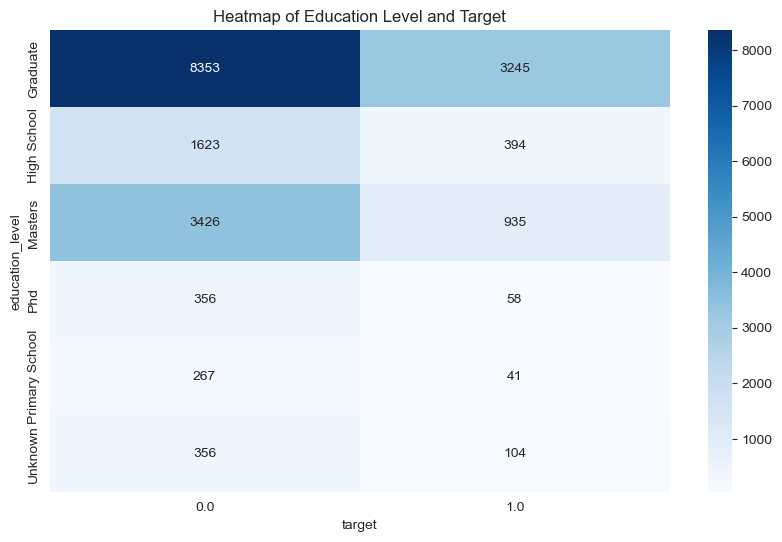

In [360]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['education_level'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Education Level and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


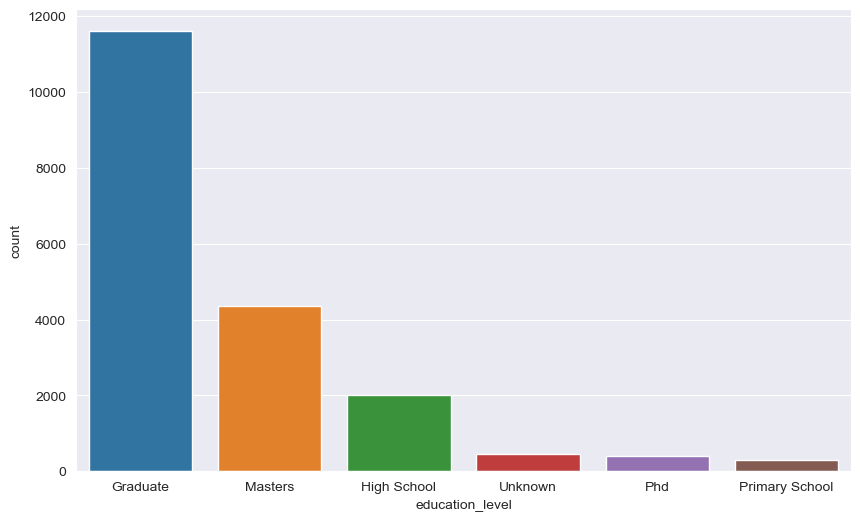

In [361]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='education_level', data=train_data, order=train_data['education_level'].value_counts().index)
plt.show()

In [362]:
# Get unique values of major_discipline
train_data['major_discipline'].unique()

array(['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major',
       'Other'], dtype=object)

In [363]:
train_data['major_discipline'].value_counts(dropna=False)

major_discipline
STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64

In [364]:
# Replace missing values in major_discipline with Unknown
train_data['major_discipline'].fillna('Unknown', inplace=True)
test_data['major_discipline'].fillna('Unknown', inplace=True)

In [365]:
print(train_data['major_discipline'].isnull().sum())

0


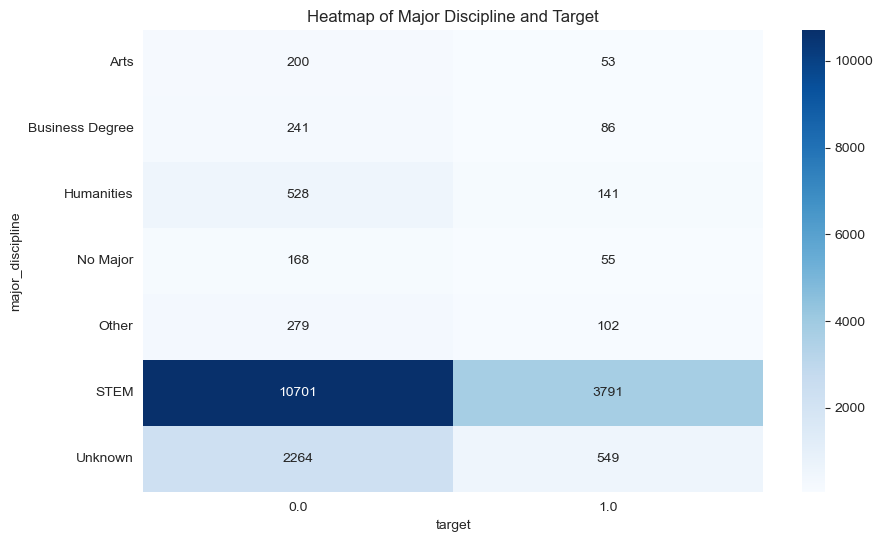

In [366]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['major_discipline'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Discipline and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


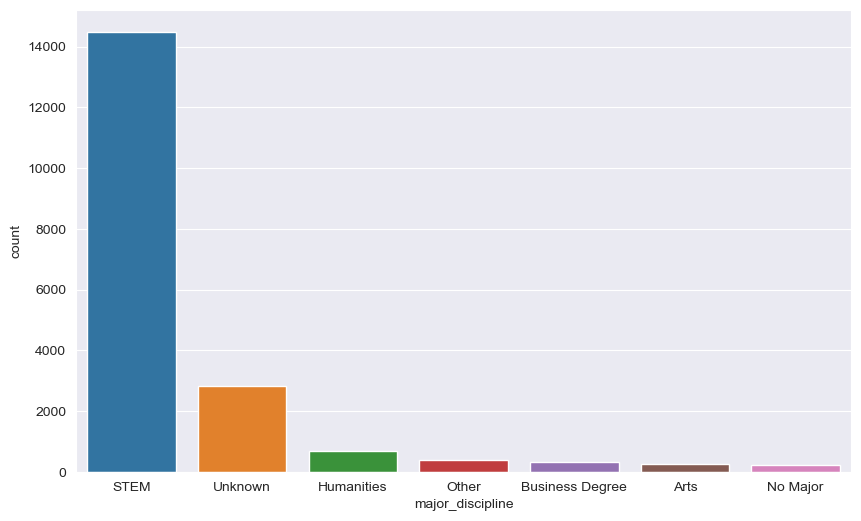

In [367]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='major_discipline', data=train_data, order=train_data['major_discipline'].value_counts().index)
plt.show()

In [368]:
# Get unique values of experience
train_data['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [369]:
# Drop rows with missing values in experience column
train_data.dropna(subset=['experience'], inplace=True)
test_data.dropna(subset=['experience'], inplace=True)

In [370]:
print(train_data['experience'].isnull().sum())

0


In [371]:
print(train_data.isnull().sum())

city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              5915
company_type              6104
last_new_job               399
training_hours               0
target                       0
dtype: int64


C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

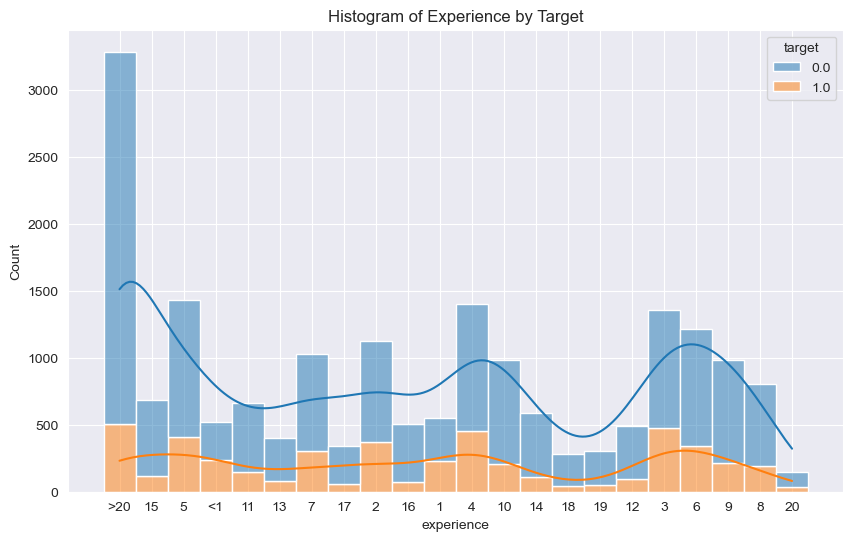

In [372]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='experience', hue='target', multiple='stack', kde=True)
plt.title('Histogram of Experience by Target')
plt.show()

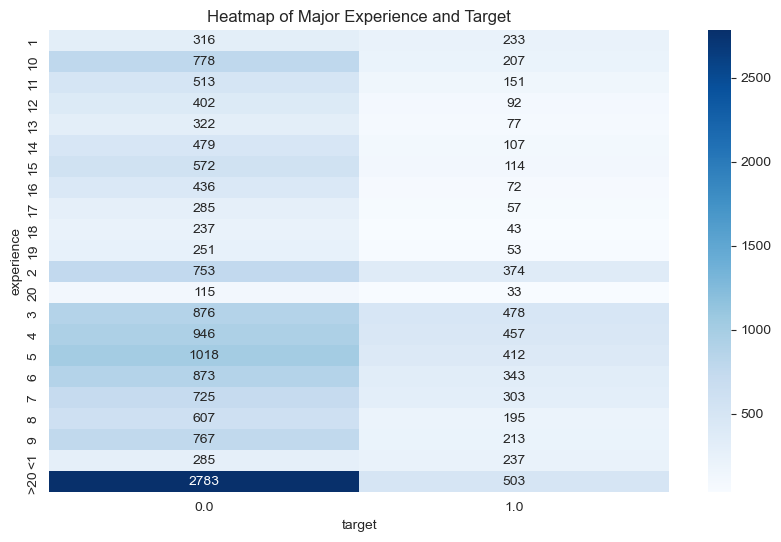

In [373]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['experience'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Experience and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


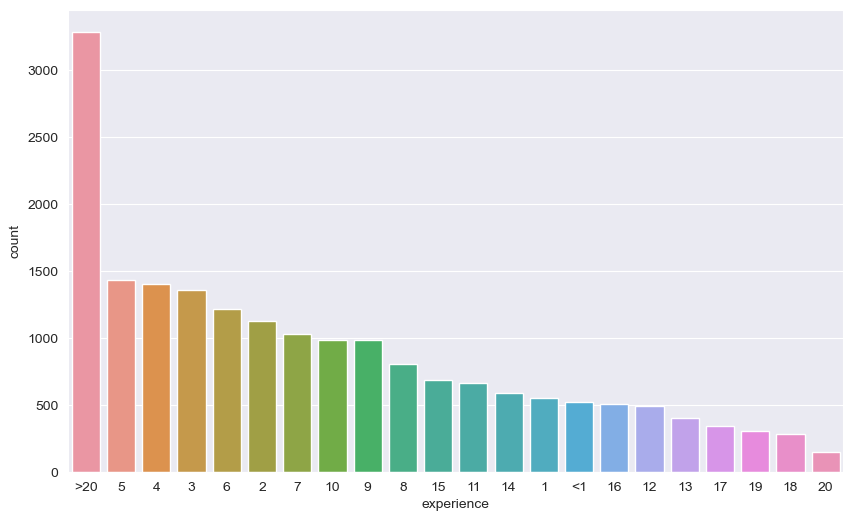

In [374]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='experience', data=train_data, order=train_data['experience'].value_counts().index)
plt.show()

In [375]:
# Count of missing values in train and test data
print(train_data.isnull().sum())
print('\n\n\n')
print(test_data.isnull().sum())

city                         0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
company_size              5915
company_type              6104
last_new_job               399
training_hours               0
target                       0
dtype: int64




city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level             0
major_discipline            0
experience                  0
company_size              621
company_type              631
last_new_job               39
training_hours              0
dtype: int64


In [376]:
# Get unique values of company_size
train_data['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

In [377]:
# Count of unique values in company_size
train_data['company_size'].value_counts(dropna=False)

company_size
NaN          5915
50-99        3078
100-500      2563
10000+       2011
10/49        1466
1000-4999    1323
<10          1304
500-999       874
5000-9999     559
Name: count, dtype: int64

In [378]:
# Replace missing values with Unknown
train_data['company_size'].fillna('Unknown', inplace=True)
test_data['company_size'].fillna('Unknown', inplace=True)

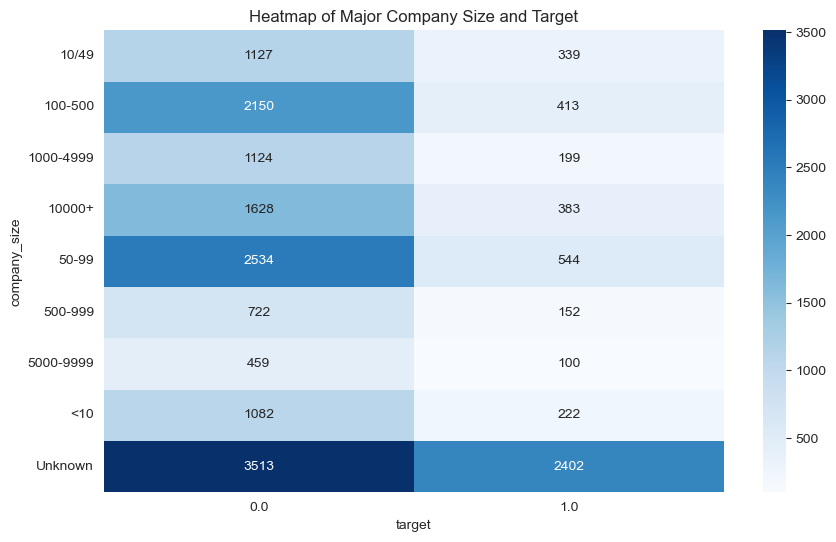

In [379]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['company_size'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Company Size and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


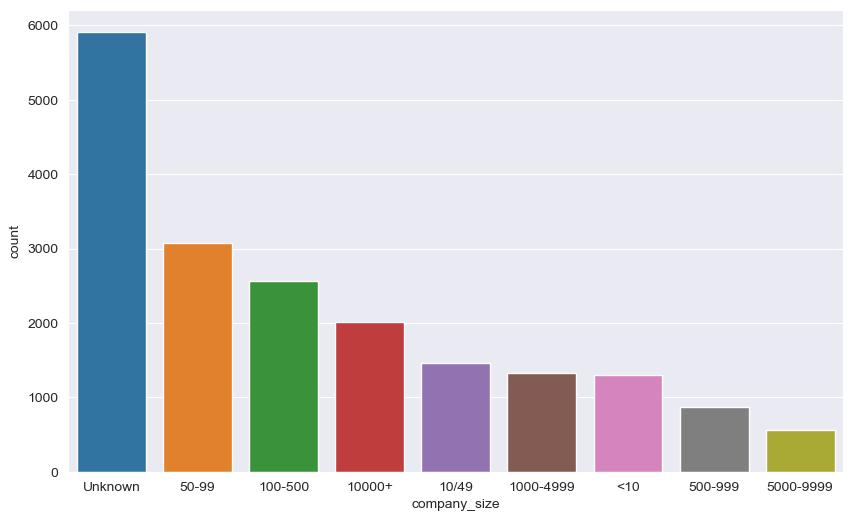

In [380]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='company_size', data=train_data, order=train_data['company_size'].value_counts().index)
plt.show()

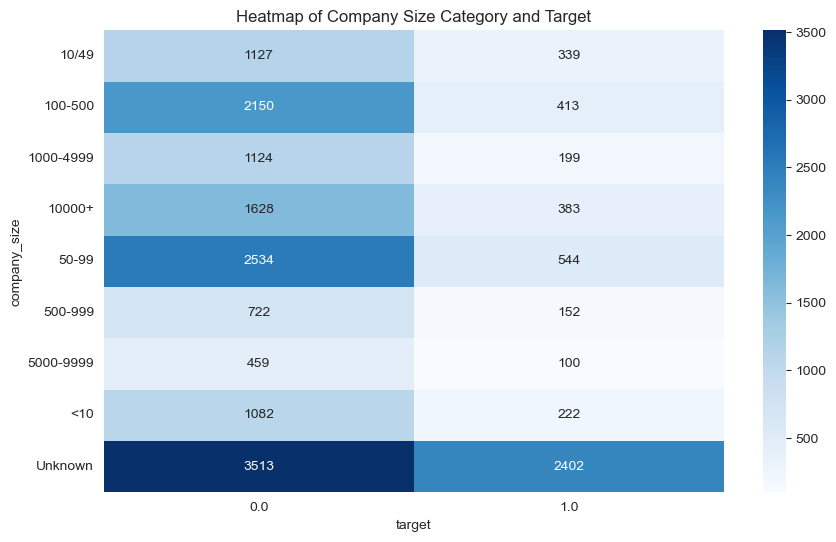

In [381]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['company_size'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Company Size Category and Target')
plt.show()

In [382]:
# Get unique values of company_type
train_data['company_type'].unique()

array([nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other',
       'Public Sector', 'NGO'], dtype=object)

In [383]:
# Count of unique values in company_type
train_data['company_type'].value_counts(dropna=False)

company_type
Pvt Ltd                9796
NaN                    6104
Funded Startup          999
Public Sector           953
Early Stage Startup     601
NGO                     519
Other                   121
Name: count, dtype: int64

In [384]:
# Replace missing values with Unknown
train_data['company_type'].fillna('Unknown', inplace=True)
test_data['company_type'].fillna('Unknown', inplace=True)

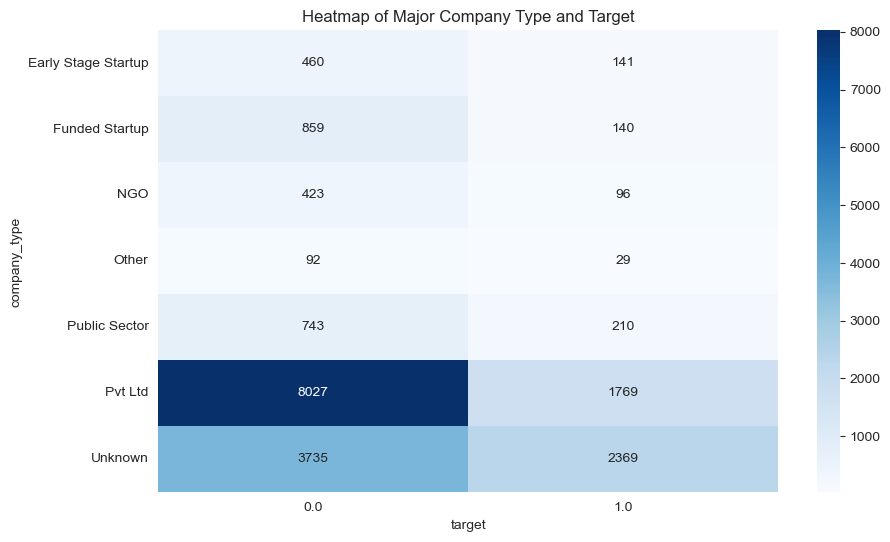

In [385]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['company_type'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Company Type and Target')
plt.show()

In [386]:
# Get unique values of last_new_job
train_data['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [387]:
# Count of unique values in last_new_job
train_data['last_new_job'].value_counts(dropna=False)

last_new_job
1        8019
>4       3283
2        2897
never    2444
4        1028
3        1023
NaN       399
Name: count, dtype: int64

In [388]:
# Drop rows with missing values in last_new_job
train_data.dropna(subset=['last_new_job'], inplace=True)
test_data.dropna(subset=['last_new_job'], inplace=True)

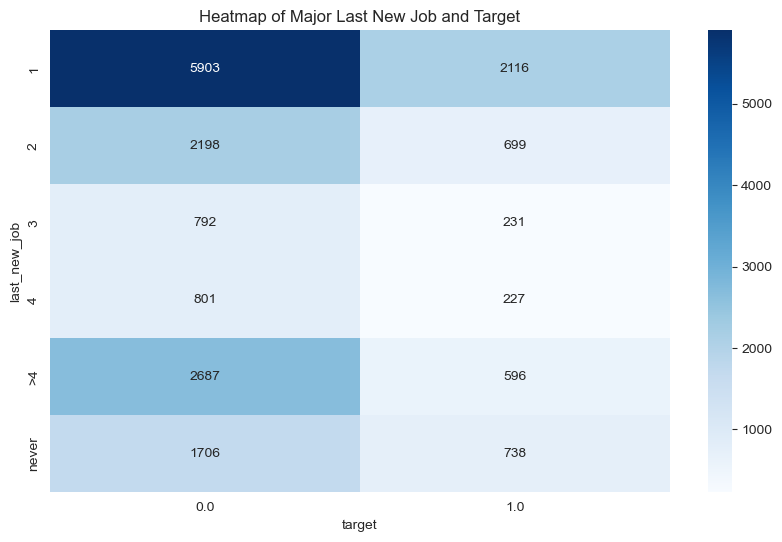

In [389]:
# Create a crosstab
cross_tab = pd.crosstab(train_data['last_new_job'], train_data['target'])

# Plot the heatmap of the crosstab
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.0f')
plt.title('Heatmap of Major Last New Job and Target')
plt.show()

C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kacpe\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


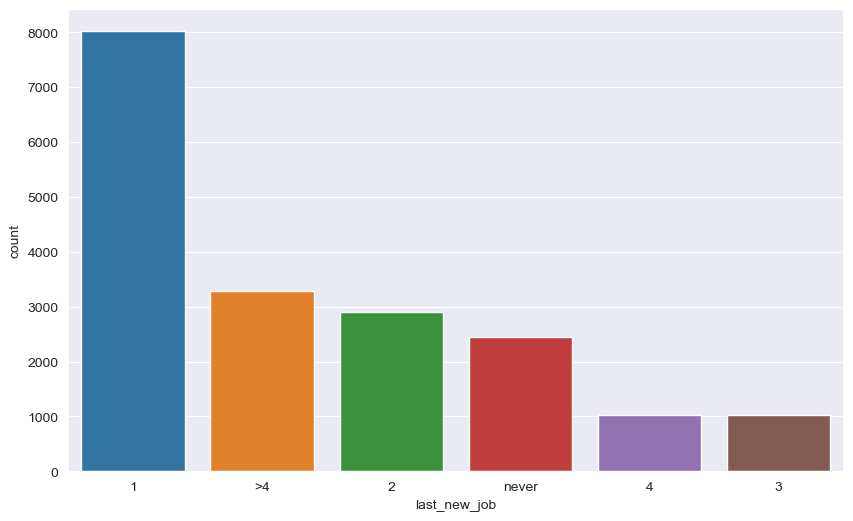

In [390]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='last_new_job', data=train_data, order=train_data['last_new_job'].value_counts().index)
plt.show()

In [391]:
# Get missing values in train and test data
print(train_data.isnull().sum())
print('\n\n\n')
print(test_data.isnull().sum())

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64




city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64


In [392]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18694 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18694 non-null  object 
 1   city_development_index  18694 non-null  float64
 2   gender                  18694 non-null  object 
 3   relevent_experience     18694 non-null  object 
 4   enrolled_university     18694 non-null  object 
 5   education_level         18694 non-null  object 
 6   major_discipline        18694 non-null  object 
 7   experience              18694 non-null  object 
 8   company_size            18694 non-null  object 
 9   company_type            18694 non-null  object 
 10  last_new_job            18694 non-null  object 
 11  training_hours          18694 non-null  int64  
 12  target                  18694 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.0+ MB


In [393]:
train_data.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,Unknown,Unknown,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,Unknown,Unknown,never,83,0.0
3,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,Unknown,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [394]:
le=LabelEncoder()
ordinal_cols=[ 'education_level',
       'major_discipline', 'experience', 'company_size',
       'last_new_job',"company_size"]
for column in ordinal_cols:
    train_data[column]=le.fit_transform(train_data[column])

In [395]:
train_data=pd.get_dummies(train_data, columns=['gender', 'relevent_experience','enrolled_university','company_type'], drop_first=False)

In [396]:
train_data.head()

,city,city_development_index,education_level,major_discipline,experience,company_size,last_new_job,training_hours,target,gender_Female,...,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown
0,city_103,0.920,0,5,21,8,0,36,1.0,False,...,False,False,True,False,False,False,False,False,False,True
1,city_40,0.776,0,5,6,4,4,47,0.0,False,...,False,False,True,False,False,False,False,False,True,False
2,city_21,0.624,0,5,15,8,5,83,0.0,False,...,True,False,False,False,False,False,False,False,False,True
3,city_115,0.789,0,1,20,8,5,52,1.0,False,...,False,False,True,False,False,False,False,False,True,False
4,city_162,0.767,2,5,21,4,3,8,0.0,False,...,False,False,True,False,True,False,False,False,False,False


In [397]:
train_data.shape

(18694, 24)

In [398]:
train_data.drop('city', axis=1, inplace=True)

train_data.head()

,city_development_index,education_level,major_discipline,experience,company_size,last_new_job,training_hours,target,gender_Female,gender_Male,...,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown
0,0.920,0,5,21,8,0,36,1.0,False,True,...,False,False,True,False,False,False,False,False,False,True
1,0.776,0,5,6,4,4,47,0.0,False,True,...,False,False,True,False,False,False,False,False,True,False
2,0.624,0,5,15,8,5,83,0.0,False,True,...,True,False,False,False,False,False,False,False,False,True
3,0.789,0,1,20,8,5,52,1.0,False,True,...,False,False,True,False,False,False,False,False,True,False
4,0.767,2,5,21,4,3,8,0.0,False,True,...,False,False,True,False,True,False,False,False,False,False


In [399]:
X = train_data.drop('target', axis=1)
y = train_data['target']

smote=SMOTE(sampling_strategy='minority')
X,y=smote.fit_resample(X,y)

In [400]:
bestfeatures = SelectKBest(score_func=chi2, k=17)
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
featureScores = featureScores.sort_values(by='Score', ascending=False)

print(featureScores)

X_selected = fit.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

                                        Feature        Score
4                                  company_size  2018.413224
21                         company_type_Unknown  1583.403145
1                               education_level  1571.019860
6                                training_hours  1460.814799
12         enrolled_university_Full time course  1349.552814
11   relevent_experience_No relevent experience   972.461291
5                                  last_new_job   299.575572
20                         company_type_Pvt Ltd   187.993554
7                                 gender_Female   173.197386
13         enrolled_university_Part time course    95.687078
0                        city_development_index    82.998223
3                                    experience    55.789795
9                                  gender_Other    25.246753
16                  company_type_Funded Startup    24.684559
15             company_type_Early Stage Startup    18.918919
19                   com

## Logistic Regression

In [402]:
logistic_reg = LogisticRegression(max_iter=1000)

logistic_reg.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.771606033717835
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      2843
         1.0       0.78      0.75      0.77      2792

    accuracy                           0.77      5635
   macro avg       0.77      0.77      0.77      5635
weighted avg       0.77      0.77      0.77      5635

Confusion Matrix: 
 [[2241  602]
 [ 685 2107]]
ROC AUC Score:  0.7714540035496625


## Random Forest Classifier